# Chapter 1: Mel Spectrum Extraction


## Step 1: Reading the wav file

Firt we import libraries that are needed for reading the wav file and signal analysis.

In [96]:
import numpy as np                      #library for linear algebra
from scipy import signal as signallib  #library for signal analysis
from wavio import read as wavio_read   #library for reading the wav file
import matplotlib.pyplot as plt     #plotting library

Now we use the wavio library to read a wav file. Make sure that file exists in the same folder as this notebook file, otherwise give the complete path to the file:

In [97]:
wav_file_path = 'test_1.wav'
wav_data = wavio_read(wav_file_path)
raw_signal = wav_data.data
sample_rate = wav_data.rate
total_samples = raw_signal[:, 0].shape[0] #There are usually 2 channels in stereo audio, We use only 1 channel (channel=0)


print("Number of samples: ", raw_signal[:, 0].shape)
print("Sample rate: ", sample_rate)

Number of samples:  (240240,)
Sample rate:  48000


## Step 2: Plotting the raw signal

### FFT

Plot a magnitude spectrum (FFT) of the raw signal:

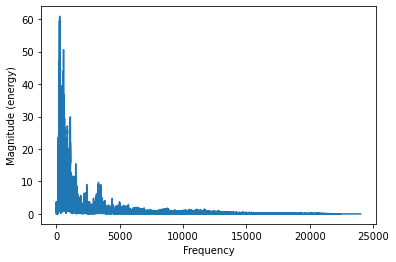

In [98]:
plt.magnitude_spectrum(raw_signal[:, 0],Fs=sample_rate)
plt.show()

### Time-domain plot
Alternatively, we can plot the signal in time domain (instead of frequency domain as in FFT). But, for this we need to use sample rate to calculate the time interval between each sample. For example, sample rate of 48000 per second means that there is 1/48000 seconds interval between each sample. That is 20.83 microseconds.

So, we create an array that represents time of each sample for plotting it on the x-axis of out plot: 

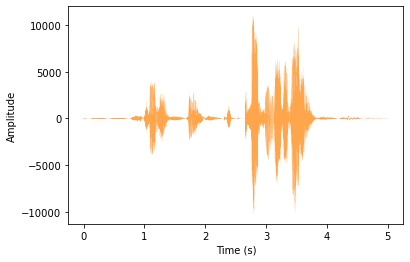

In [99]:
x_axis_time = np.arange(0, total_samples, 1) / sample_rate #This gives us the x-axis time series for all samples

#Plotting:
plt.plot(x_axis_time, raw_signal, linewidth=0.1, alpha=0.7, color='#ff7f00')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.show()

## Step 3: Framing

We don't want to analyze the magnitude and frequency of whole recording, instead we want to split the recording into small segments and then analyze each segment frame by frame.
First we create a separate function that does the framing:

In [100]:
def frame_segmentation(signal, sample_rate, window_length=0.025, window_step=0.010):

    #Framing
    frame_length, frame_step = window_length * sample_rate, window_step * sample_rate  # Convert from seconds to samples
    signal_length = len(signal) #same as total_samples
    frame_length = int(round(frame_length))
    frame_step = int(round(frame_step))
    num_frames = int(np.ceil(float(np.abs(signal_length - frame_length)) / frame_step))  # Make sure that we have at least 1 frame

    if(num_frames < 1):
        raise Exception("Clip length is too short. It should be atleast " + str(window_length*2)+ " frames")

    pad_signal_length = num_frames * frame_step + frame_length
    z = np.zeros((pad_signal_length - signal_length))
    pad_signal = np.append(signal, z) # Pad Signal to make sure that all frames have equal number of samples without truncating any samples from the original signal

    indices = np.tile(np.arange(0, frame_length), (num_frames, 1)) + np.tile(np.arange(0, num_frames * frame_step, frame_step), (frame_length, 1)).T
    frames = pad_signal[indices.astype(np.int32, copy=False)]

    #Hamming Window
    frames *= np.hamming(frame_length)
    #frames *= 0.54 - 0.46 * numpy.cos((2 * numpy.pi * n) / (frame_length - 1))  # Explicit Implementation **
    #print (frames.shape)
    return frames, signal_length


Then we apply this function to our `raw_signal`. Before we do that, we apply an emphasis filter on the raw signal to emphasize the power of higher frequencies. This is because in an audio signal, high frequencies usually have less power but they are percived by human ear as high powered. Emphasis of higher frequencies is important to equalize the signal to the perception of human ear. This can done by a first order filter that applies a relative gain on the higher frequencies:

In [101]:
emphasize_ratio = 0.70
emphasized_signal = np.append(raw_signal[0], raw_signal[1:] - emphasize_ratio * raw_signal[:-1])

#Now split the signal into 25ms segments, at 10ms stride:
frames, total_samples = frame_segmentation(emphasized_signal, sample_rate, window_length=0.025, window_step=0.010)

print ("Array shape of 'frames':", frames.shape)
#It shows that there are total 498 frames, and each frame has 1200 sample

Array shape of 'frames': (498, 1200)


Now we can analyze each 25ms frame separately. For example we can analyze the spectrogram for the first frame:

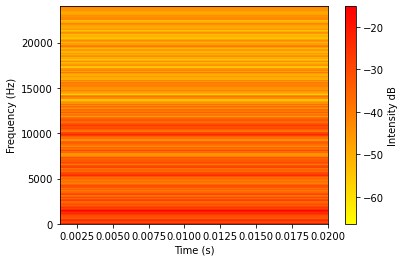

In [102]:
Pxx, freqs, bins, im = plt.specgram(frames[0], Fs=sample_rate, NFFT=1024, cmap=plt.get_cmap('autumn_r'))
cbar=plt.colorbar(im)
plt.xlabel('Time (s)')
plt.ylabel('Frequency (Hz)')
cbar.set_label('Intensity dB')

## Step 4: Mel filter banks
This figure shows the shape of trinagular mel-filter banks.
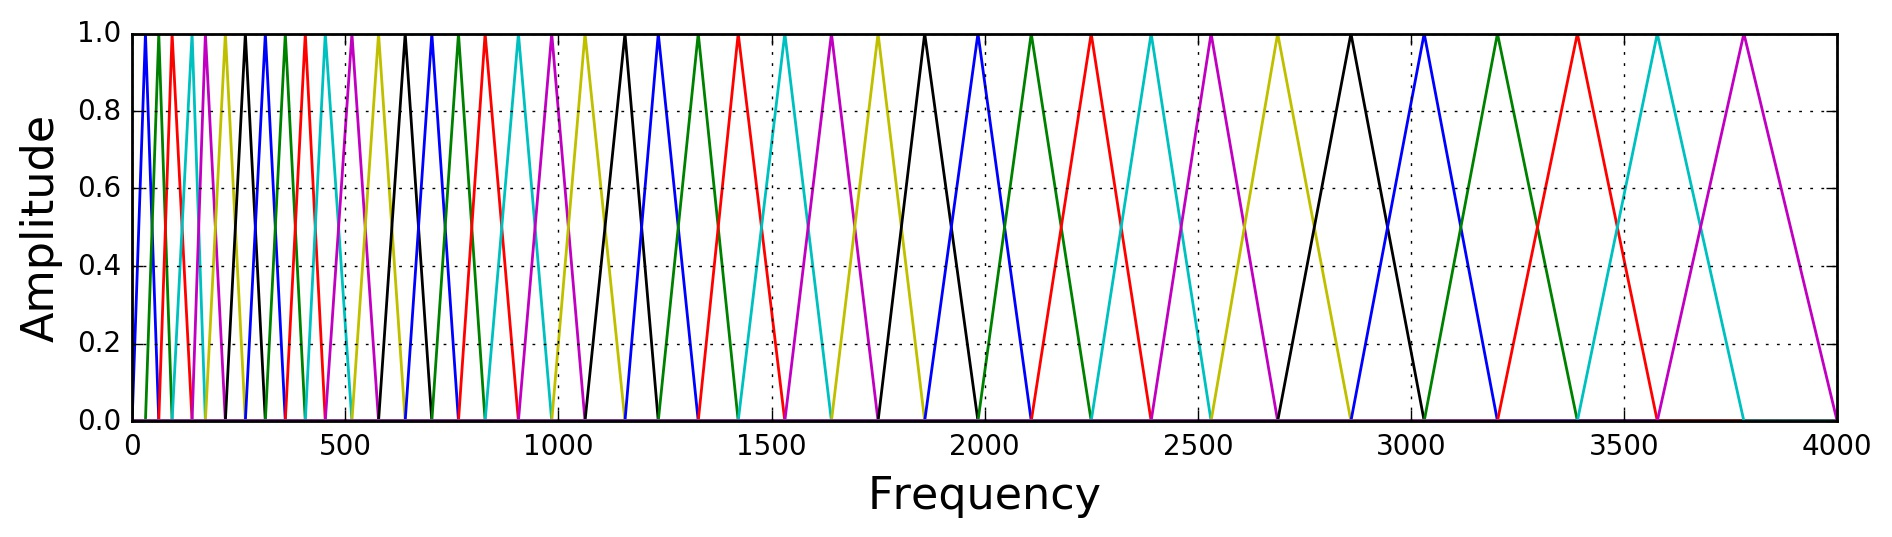
The following function first creates a power spectrum using the FFT of the signal, then that power spectrum `pow_frames` is filtered by Mel-filter banks.

In [103]:
def get_filter_banks(frames, sample_rate, f0_min=60, f0_max=4000, num_filt=128, amp_DB=1, norm=0):
    '''
    Fourier-Transform and Power Spectrum

    return filter_banks, hz_points

    filter_banks: array-like, shape = [n_frames, num_filt]

    hz_points: array-like, shape = [num_filt], center frequency of mel-filters
    '''

    NFFT = num_filt*32      #FFT bins (equally spaced - Unlike mel filter)
    mag_frames = np.absolute(np.fft.rfft(frames, NFFT))  # Magnitude of the FFT
    pow_frames = ((1.0 / NFFT) * ((mag_frames) ** 2))  # Power Spectrum

    #Filter Banks
    nfilt = num_filt
    low_freq_mel = (2595 * np.log10(1 + (f0_min) / 700))
    high_freq_mel = (2595 * np.log10(1 + (f0_max) / 700))  # Convert Hz to Mel
    mel_points = np.linspace(low_freq_mel, high_freq_mel, nfilt + 2)  # Equally spaced in Mel scale
    hz_points = (700 * (10**(mel_points / 2595) - 1))  # Convert Mel to Hz
    bin = np.floor((NFFT + 1) * hz_points / sample_rate)

    n_overlap = int(np.floor(NFFT / 2 + 1))
    fbank = np.zeros((nfilt, n_overlap))
    
    for m in range(1, nfilt + 1):
        f_m_minus = int(bin[m - 1])   # left
        f_m = int(bin[m])             # center
        f_m_plus = int(bin[m + 1])    # right
        
        for k in range(f_m_minus, f_m):
            fbank[m - 1, k] = (k - bin[m - 1]) / (bin[m] - bin[m - 1])
        for k in range(f_m, f_m_plus):
            fbank[m - 1, k] = (bin[m + 1] - k) / (bin[m + 1] - bin[m])
    filter_banks = np.dot(pow_frames, fbank.T)
    filter_banks = np.where(filter_banks == 0, np.finfo(float).eps, filter_banks)  # Numerical Stability
    if(amp_DB):
        filter_banks = 20 * np.log10(filter_banks)  # dB
    if(norm):
        filter_banks -= (np.mean(filter_banks)) #normalize if norm=1

    return filter_banks, hz_points


Now we call the above function using set parameters, i.e., frequency range 60-4000 Hz, Number of filter banks is `num_filt=128`, we want the convert the resultant amplitude to DB (`amp_DB=1`), and normalization of amplitude is disabled (`norm=0`)

Filter array shape:  (498, 128)


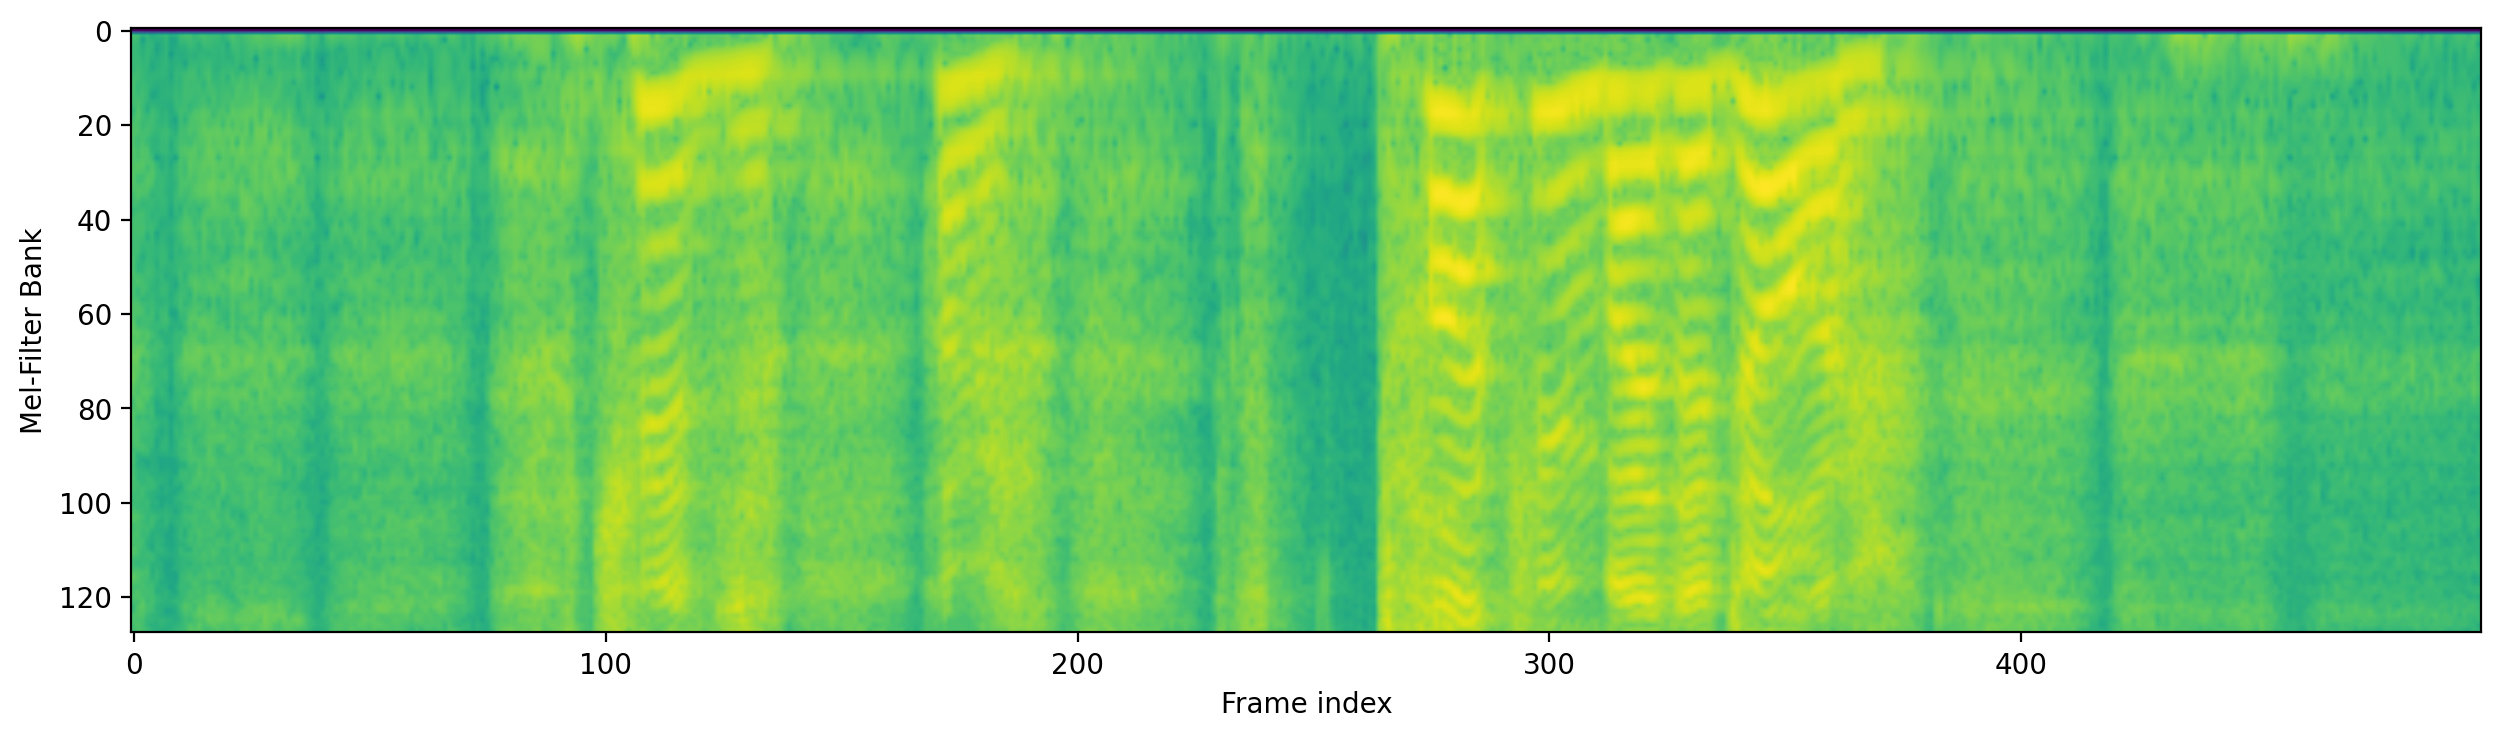

In [200]:
num_filt = 128

filter_banks, hz_points = get_filter_banks(frames, sample_rate, f0_min=60, f0_max=4000, num_filt=num_filt, amp_DB=1, norm=0)

print("Filter array shape: ",filter_banks.shape)

#Plot the mel-spectrogram
plt.imshow(np.transpose(filter_banks), interpolation='bilinear')
plt.xlabel('Frame index')
plt.ylabel('Mel-Filter Bank')
plt.rcParams["figure.figsize"] = (24,4)
plt.show()

In the above plot, the y-axis shows the filter number instead of frequency in Hz. We can use the `hz_points` to plot the central frequency of each filter bank:

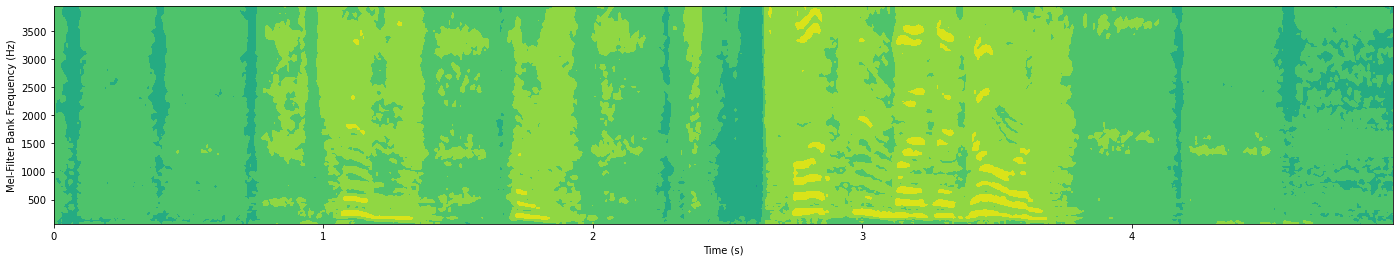

In [139]:
frame_time = np.arange(0, filter_banks.shape[0], 1) * 0.01  #multiply frame_index with window_step=0.010

plt.contourf(frame_time, hz_points[1:num_filt+1], np.transpose(filter_banks))
plt.xlabel('Time (s)')
plt.ylabel('Mel-Filter Bank Frequency (Hz)')
plt.rcParams["figure.figsize"] = (24,4)
plt.show()

## Step 5: MFCCs (Optional)

It turns out that filter bank coefficients computed in the previous step are highly correlated, which could be problematic in some machine learning algorithms. Therefore, we can apply Discrete Cosine Transform (DCT) to decorrelate the filter bank coefficients and yield a compressed representation of the filter banks. Typically, for Automatic Speech Recognition (ASR), the resulting cepstral coefficients 2-13 are retained and the rest are discarded; `num_ceps = 13`. The reasons for discarding the other coefficients is that they represent fast changes in the filter bank coefficients and these fine details don’t contribute to Automatic Speech Recognition (ASR).

In [141]:
from scipy.fftpack import dct

num_ceps = 13
mfcc = dct(filter_banks, type=2, axis=1, norm='ortho')[:, 1 : (num_ceps + 1)] # Keep 2-13

One may apply sinusoidal liftering1 to the MFCCs to de-emphasize higher MFCCs which has been claimed to improve speech recognition in noisy signals.

In [146]:
(nframes, ncoeff) = mfcc.shape
n = np.arange(ncoeff)
cep_lifter = 22
lift = 1 + (cep_lifter / 2) * np.sin(np.pi * n / cep_lifter)
mfcc *= lift  #apply lift

Now plot the MFCCs:

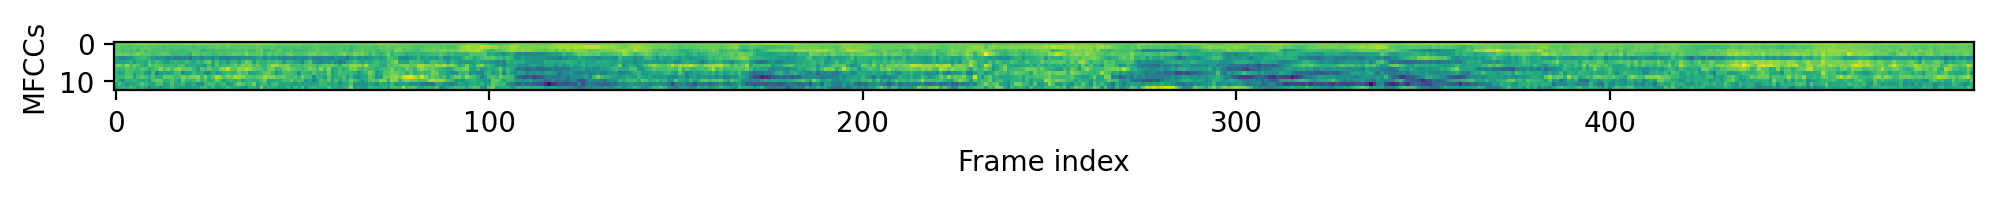

In [197]:
plt.imshow(np.transpose(mfcc), interpolation='antialiased')
plt.rcParams["figure.figsize"] = (12,60)
plt.rcParams['figure.dpi'] = 200
plt.xlabel('Frame index')
plt.ylabel('MFCCs')
plt.show()

Because whole clip is too long, we should zoom in to first 50 frames:

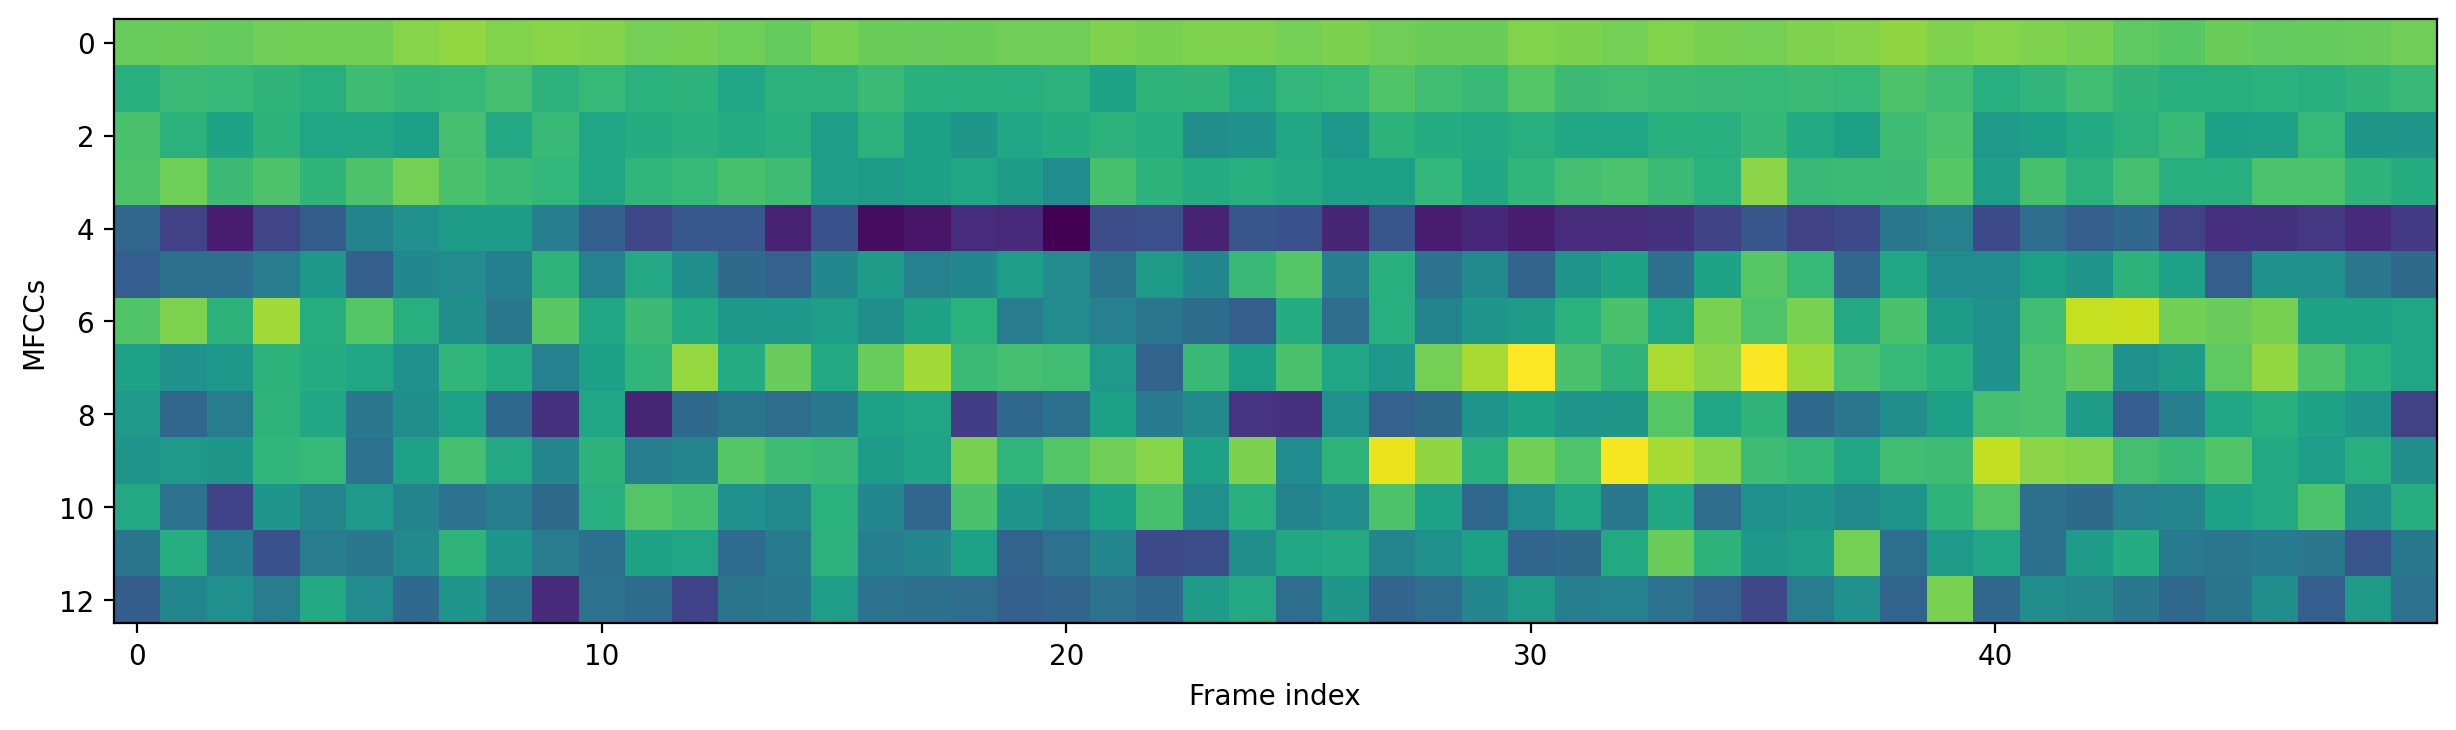

In [201]:
plt.imshow(np.transpose(mfcc[0:50]), interpolation='antialiased')
plt.rcParams["figure.figsize"] = (12,60)
plt.rcParams['figure.dpi'] = 200
plt.xlabel('Frame index')
plt.ylabel('MFCCs')
plt.show()

The End. In next chapter we will talk about the formant extraction from mel-spectrogram.